### *PhotoDissociation Region Toolbox Notebooks*
-------------------------------------------------------------

# Example 3: Determining Radiation Field and Density

This example shows use the PDRT Toolbox to determine the PDR radiation field $G_0$ and hydrogen nucleus volume density $n$ from your spectral line and far-infrared (FIR) data into the PDR Toolbox.  The case is for single-pixel observations (as in the classic PDRT website).   If you have not gone through the Measurements and ModelSets examples, you should do them first.


### 3a. Determining Radiation Field and Density from single value Measurements
Following the example on how to use Measurements, create Measurements for your observations.

In [1]:
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
import pdrtpy.pdrutils as utils
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.lineratioplot import LineRatioPlot
from astropy.nddata import StdDevUncertainty
import astropy.units as u
import numpy as np

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [2]:
myunit = "erg s-1 cm-2 sr-1" # my default unit for value and error
m1 = Measurement(data=30.,uncertainty = StdDevUncertainty(5.0),identifier="OI_145",unit=myunit)
m2 = Measurement(data=11.,uncertainty = StdDevUncertainty(2.5),identifier="CI_609",unit=myunit)
m3 = Measurement(data=1.3E9,uncertainty = StdDevUncertainty(2E8),identifier="CO_21",restfreq="230.538 GHz", unit="K km/s")
m4 = Measurement(data=100.,uncertainty = StdDevUncertainty(10.),identifier="CII_158",unit=myunit)
a = [m1,m2,m3,m4]

Now create the fitting tool, feeding it your observations.   It will use the default  Wolfire/Kauffman ModelSet.

In [3]:
p = LineRatioFit(ModelSet("wk2020",z=1),measurements=a)

### Now run it! 
Note the K km s$^{-1}$ get converted on the fly to erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$.  You will get warned that there are no beam parameters in the Measurements.

In [4]:
p.run()

/home/mpound/src/pdrtpy/pdrtpy/tool/lineratiofit.py:313: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


### The results are stored in member variables as Measurements.
`pdrutils` has methods to convert between the common radiation field measures. Note: the errors in $n$ and $G_0$ have been set to `NaN` because we don't have a good way to calculate them yet.

In [5]:
print("n=",p.density)
print("G0=",p.radiation_field)
# example conversions
print(utils.toDraine(p.radiation_field))
print(utils.tocgs(p.radiation_field))
print(utils.toMathis(p.radiation_field))

n= 133352.1432163324 +/- nan 1 / cm3
G0= 0.028452466521282346 +/- nan erg / (cm2 s)
10.46046563282439 +/- nan Draine
0.028452466521282346 +/- nan erg / (cm2 s)
15.719594763139416 +/- nan Mathis


## Now on to plotting!
Create a plotter from the tool.  For single pixel measurements, you can plot the observed ratios in (G0,n) space like the classic PDRT.  

In [6]:
plot = LineRatioPlot(p)

In [7]:
# since you only have one pixel, asking to plot density, radiation field, or both just prints
plot.show_both()

(17.782791575801465 +/- nan Habing, 133352.1432163324 +/- nan 1 / cm3)

### LineRatioPlot has many options for how plots are displayed.
You can vary colormap, contours, units, etc.  For an exhaustive list, see the documentation web page or type `help(LineRatioPlot)`.
    

#### plot your observed ratios with errors on the matching models 

autolev min 0.000447 max 33.885349
autolev min 0.000006 max 3787.878662


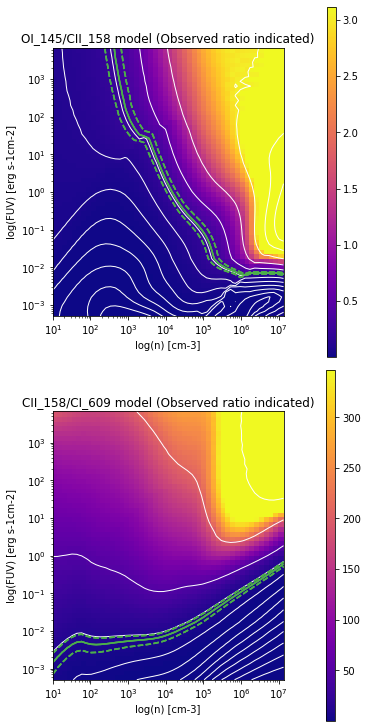

In [19]:
plot.ratios_on_models()
# Save the figure to a PNG
plot._figure.savefig("modelfits.png")

#### Plot the reduced chisquare in (n,G0) space, using an alternative colormap and label the contours

autolev min 0.060538 max 2805973.001242


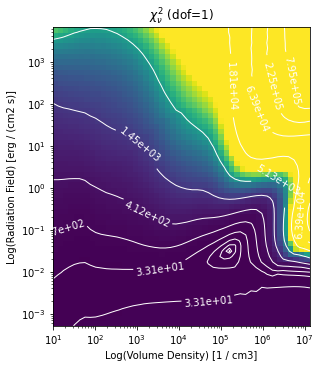

In [9]:
plot.reduced_chisq(cmap='viridis',label=True,colors='white')

#### How about just contours? We need to specify color since default contour color is white

autolev min 0.060538 max 2805973.001242


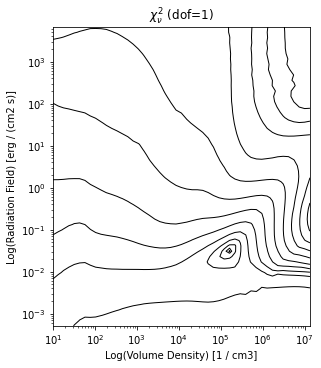

In [10]:
plot.reduced_chisq(image=False,colors='k')

#### Overlay all the ratios and errors in model space.

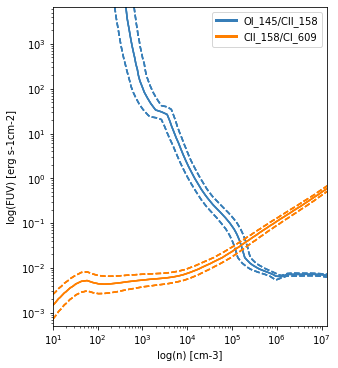

In [11]:
plot.overlay_all_ratios()

### What are the model ratios matching these observation

In [15]:
p._modelratios.keys()

dict_keys(['OI_145/CII_158', 'CII_158/CI_609'])

### Plot one of the model ratios

autolev min 0.000006 max 3787.878662


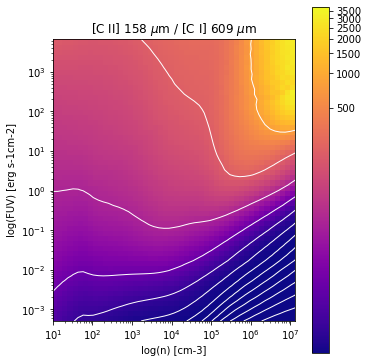

In [12]:
plot.modelratio("CII_158/CI_609")

### save the most recent figure to a PNG

In [16]:
plot._figure.savefig("CII_CI.png")